### Ruth Murray-Clay, Astrophysics II, Problem Set 5

Problem 1: Numerical evolution of a hydrostatic atmosphere to an isothermal Parker wind.

Getting this to work is hard!  In general, you will need some combination of high radial resolution and small time steps.  The more clever you can be about your numerical scheme and boundary conditions, the less resolution you can get away with in both radius and time.  (More clever schemes than the below often split up fluxes through the boundaries of cells and updates of the values at the centers of cells, which allows for better conservation of quantities that are supposed to be conserved.)

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.optimize import fsolve

In [2]:
# constants in cgs units
G = c.G.cgs.value
k = c.k_B.cgs.value
mH = c.m_p.cgs.value

yr = u.yr.to(u.s)
day = u.day.to(u.s)
hour = u.hour.to(u.s)

Pick some planet parameters and a wind temperature.  You can choose whatever you like, but make sure that the temperature is such that the sonic point is above the planet's surface but not more than a few planetary radii away.

In [3]:
Rp = 6.4e8 # cm ; planet radius
Mp = 6e27 # g ; planet mass
T = 1e3 # K ; wind temperature
mu = mH # g ; mean molecular weight of atmospheric gas

In [4]:
cs = np.sqrt(k*T/mu)  # isothermal sound speed
H = Rp**2*cs**2/G/Mp  # scale height of atmosphere at the surface

Set up the radial grid.

I will use $x \equiv \ln r$ for my independent variable since that gives me more points near the base and lets me keep the bottom of the atmosphere hydrostatic with a smaller number of radial cells. (Note for future reference that variable grid sizing can be helpful, but it can also make some of the fancier numerical algorithms break.)  If you want to try it with a linear grid instead, you can--just be aware that you'll need small enough grid cells that the there are at least several cells per scale height at the bottom of the atmosphere.  This can make the code take a long time to run.

You may have to fuss with dx depending on the values you picked above.

In [5]:
dx = 1e-2  # the radial step size in x
x = np.arange(np.log(Rp),np.log(5.0*Rp),dx)  # I am using np.arange instead of np.linspace since having a known fixed step size is helpful.
r = np.exp(x)
nrs = len(r)

Our initial condition will be the hydrostatic solution, but with low pressure at the outer boundary.  Later, we'll smooth the lower pressure part over a few cells to reduce wave lauching and make the solution more stable.

Initial conditions:

Use the hydrostatic isothermal atmsophere solution as the initial condition.

The hydrostatic isothermal atmosphere has zero velocity. 

Calculate and input the hydrostatic isothermal solutions's density profile.  It will depend on:
$\rho_0$, the density at the lower boundary which is set below, 
$R_p$, the radius of the planet which is set above, and 
$H$, the scale height which is calculated above.  

The hydrostatic isothermal atmosphere has density profile
$\rho = \rho_0 e^{(R_p/H)(R_p/r - 1)}$, where $H = (R_p^2 c_s^2)/(GM_p)$.  Use this as the initial density distribution.

In [7]:
rho0 = 1e-11 # g/cm^3; The density at the lower boundary.
rho_hydrostat = rho0*np.exp((Rp/H)*(Rp/r-1.0)) # Isothermal hydrostatic atmosphere

# the array to hold the density distribution
rho = np.zeros(nrs) 
np.copyto(rho, rho_hydrostat) # Copy the hydrostatic solution in as the starting point

# in hydrostatic equilibrium, the velocity is zero
v = np.zeros(nrs)

Calculate the transonic solution on the log grid so we can use it as a reference line.

Add in the analytic expression for the sonic point radius.

Add in the function for the numerical solver from Problem Set 4, Problem 2 part (a).

Use the solution for v at r=Rp to calculate Mdot.

Get the density as a function of r from Mdot = constant.

In [10]:
rs = G*Mp/(2.*cs**2) # sonic point radius

vguess = np.zeros(nrs) # guess 0 for the subsonic part
vguess[r > rs] = 2.0*cs # guess 2c_s for the supersonic part, to help it find the transonic solution

# function for numerical solver: This equal to zero is our equation for the velocity
def f_v(v, r, cs, rs):
    return( v*np.exp(-v**2/(2*cs**2)) - cs*(r/rs)**(-2.)*np.exp(3./2.-2.*rs/r) )

v_wind_solved = fsolve(f_v, vguess, args=(r,cs,rs,)) # solve

# use the solution for v at r = Rp to calculate Mdot
Mdot = 4.*np.pi*Rp**2*rho0*v_wind_solved[0]
rho_wind_solved = Mdot/(4.*np.pi*r**2*v_wind_solved) # get the density from Mdot = constant

Set up the time step.  Remember that the Courant condition requires $c_s dt \lesssim dr$, meaning that a sound wave should not be able to cross an entire cell in one time step. 

In [11]:
dt = 0.1 # s ; integration step size in t
tfinal = 3e4  # s (about 8 hours); total length of the integration
times = np.arange(0,tfinal,dt)
ntimes = len(times)

Saving the output at every timestep would be too much for the computer to handle, so I'll set up an interval at which I save the outputs.  Also, create arrays in which to save the outputs.

In [12]:
dt_out = 100.0 # s ; output interval
nts_out = int(np.floor(ntimes*dt/dt_out)) + 1
# arrays to keep the results
rho_out = np.zeros([nts_out,nrs])
v_out = np.zeros([nts_out,nrs])

Add the initial conditions to our input arrays

In [13]:
np.copyto(rho_out[0], rho)
np.copyto(v_out[0], v)

#### The integration is in a big for loop, so I've explained the contents in a big lump first:

#### *Equations:*

Mass conservation:

$\frac{\partial \rho}{\partial t} + \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\rho v\right) = \frac{\partial \rho}{\partial t} + \frac{2}{r}\rho v + v\frac{\partial\rho}{\partial r} + \rho\frac{\partial v}{\partial r} = 0$

Momentum conservation:

$ \rho \frac{\partial v}{\partial t} + \rho v\frac{\partial v}{\partial r} = -c_s^2\frac{\partial \rho}{\partial r} - \rho \frac{GM}{r^2}$

To allow for logarithmic spacing in the radius bins, transform from $r$ to $x = \ln(r)$ so that $r = e^x$.

Transformed equations:

$\frac{\partial \rho}{\partial t} = -e^{-3x}\frac{d}{dx}\left(\rho v e^{2x}\right) = -e^{-x} ( 2\rho v + v \frac{d\rho}{dx} + \rho \frac{dv}{dx} )$

$\frac{\partial v}{\partial t} = -ve^{-x}\frac{dv}{dx} - \frac{c_s^2}{\rho} e^{-x}\frac{d\rho}{dx} - GMe^{-2x}$

Now we need to discretize.  The index $i$ refers to the time step and the index $j$ refers to the radial location.

$\rho_{avg} = (1/2)(\rho_{j+1} + \rho_{j-1})$

$\Delta\rho =  (1/2)(\rho_{j+1} - \rho_{j-1})$

and so on

$\frac{\rho_j(t_{i+1}) - \rho_j(t_i)}{dt} =  -e^{-x_{avg}}\left(2\rho_{avg}v_{avg} + \rho_{avg}\Delta v/dx + v_{avg} \Delta \rho/dx\right)$

$\frac{v_j(t_{i+1}) - v_j(t_i)}{dt} =  -v_{avg}e^{-x_{avg}}\Delta v/dx - (c_s^2/\rho_{avg})e^{-x_{avg}} \Delta\rho/dx - GMe^{-2x_{avg}}$

From the above, we can get, for example, $\rho_j(t_{i+1})$ from $\rho_j(t_i)$, stepping the solution forward in time.

#### *Boundary conditions:*

To try to "let the flow do what it wants to," we'll use the same update equations for $\rho$ and $v$ at the inner and outer boundaries that we do in the middle of the flow, but we'll have to adjust the "avg" and "$\Delta$" values because one of the values we need isn't there. You can see the choices that I made in the code below.

We will need a small density (equivalent to small pressure) at the outer boundary to get the outflow started. Just setting the cell at the outer boundary to zero pressure is a big contrast that leads to destabilizing waves, so we'll reduce the density at the outer boundary more smoothly in our initial condition:

In [14]:
nsmooth = 5 # number of cells to smooth the lower pressure region over
factor = np.linspace(0.5,1.0,nsmooth)  # density at the outer boundary is gradually reduced to 0.5 times its hydrostatic value
for i in range(nsmooth): rho[nrs-1-i] = rho[nrs-1-i]*factor[i]   

To coax the code into not going unstable, I add two more fixes: (1) I damp the density to the hydrostatic solution in the first 5 cells (well below the sonic point where this is a good approximation) so that waves can't grow there. (2) I give the code a little nudge over the sonic point where v ~ cs to help it with the zero divided by zero.

In [15]:
# These arrays will be used to update to the next time step. 
new_rho = np.zeros(nrs)
new_v = np.zeros(nrs)

t = 0.0 s
at outer boundary vout/cs =  0.00020223368434119194


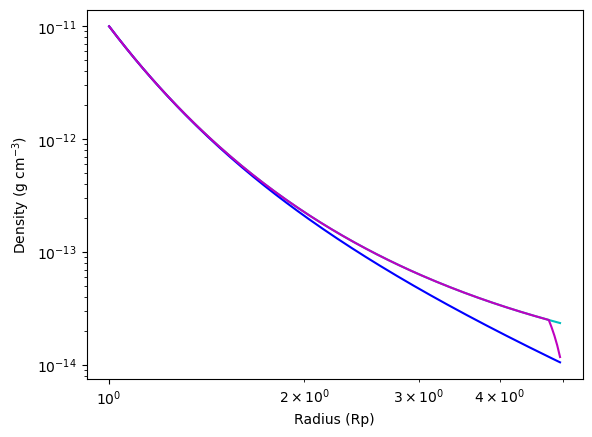

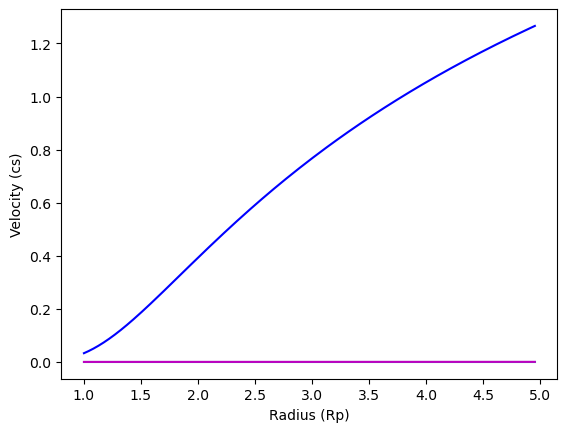

t = 100.0 s
t = 200.0 s
t = 300.0 s
t = 400.0 s
t = 500.0 s
t = 600.0 s
t = 700.0 s
t = 800.0 s
t = 900.0 s
t = 1000.0 s
t = 1100.0 s
t = 1200.0 s
t = 1300.0 s
t = 1400.0 s
t = 1500.0 s
t = 1600.0 s
t = 1700.0 s
t = 1800.0 s
t = 1900.0 s
t = 2000.0 s
at outer boundary vout/cs =  0.8484133801717875


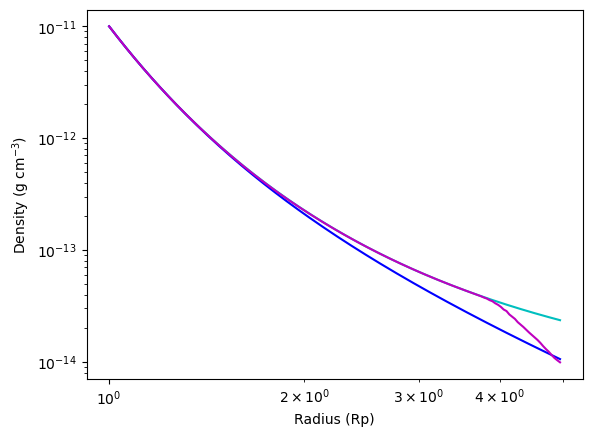

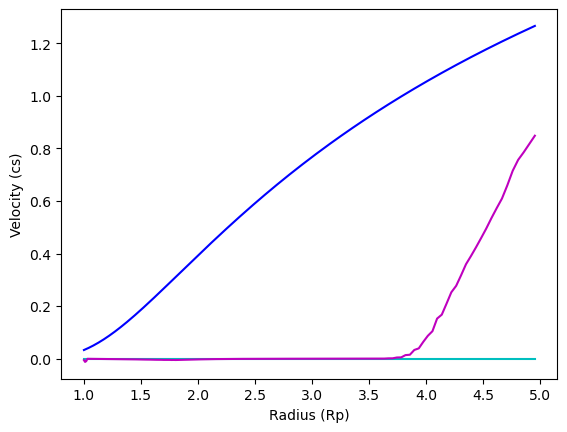

t = 2100.0 s
t = 2200.0 s
t = 2300.0 s
t = 2400.0 s
t = 2500.0 s
t = 2600.0 s
t = 2700.0 s
t = 2800.0 s
t = 2900.0 s
t = 3000.0 s
t = 3100.0 s
t = 3200.0 s
t = 3300.0 s
t = 3400.0 s
t = 3500.0 s
t = 3600.0 s
t = 3700.0 s
t = 3800.0 s
t = 3900.0 s
t = 4000.0 s
at outer boundary vout/cs =  0.9412246159740918


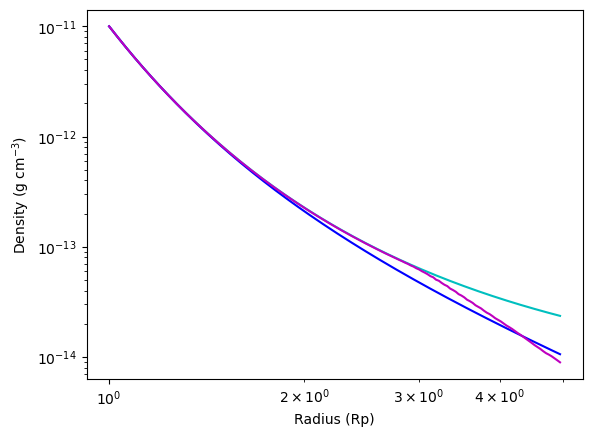

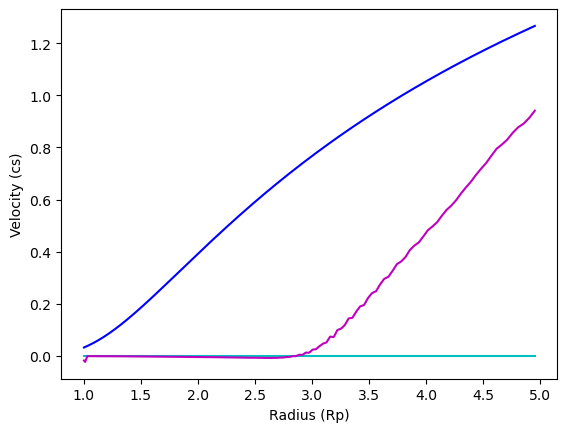

t = 4100.0 s
t = 4200.0 s
t = 4300.0 s
t = 4400.0 s
t = 4500.0 s
t = 4600.0 s
t = 4700.0 s
t = 4800.0 s
t = 4900.0 s
t = 5000.0 s
t = 5100.0 s
t = 5200.0 s
t = 5300.0 s
t = 5400.0 s
t = 5500.0 s
t = 5600.0 s
t = 5700.0 s
t = 5800.0 s
t = 5900.0 s
t = 6000.0 s
at outer boundary vout/cs =  1.0027584588261456


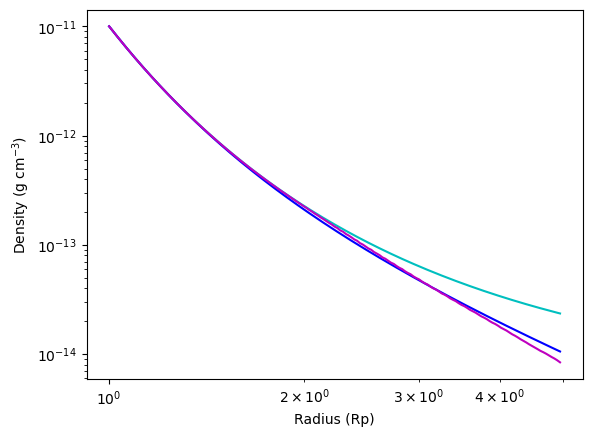

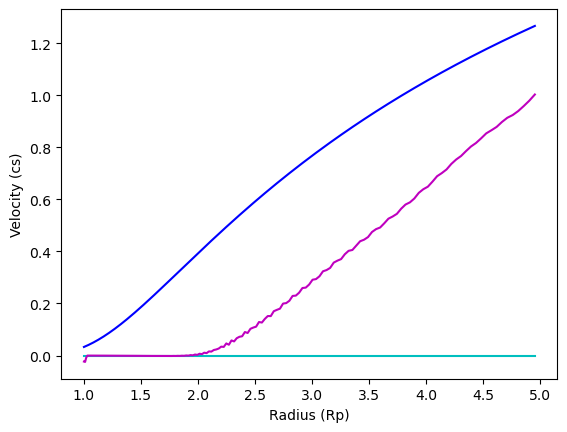

t = 6100.0 s
t = 6200.0 s
t = 6300.0 s
t = 6400.0 s
t = 6500.0 s
t = 6600.0 s
t = 6700.0 s
t = 6800.0 s
t = 6900.0 s
t = 7000.0 s
t = 7100.0 s
t = 7200.0 s
t = 7300.0 s
t = 7400.0 s
t = 7500.0 s
t = 7600.0 s
t = 7700.0 s
t = 7800.0 s
t = 7900.0 s
t = 8000.0 s
at outer boundary vout/cs =  1.0425575328264347


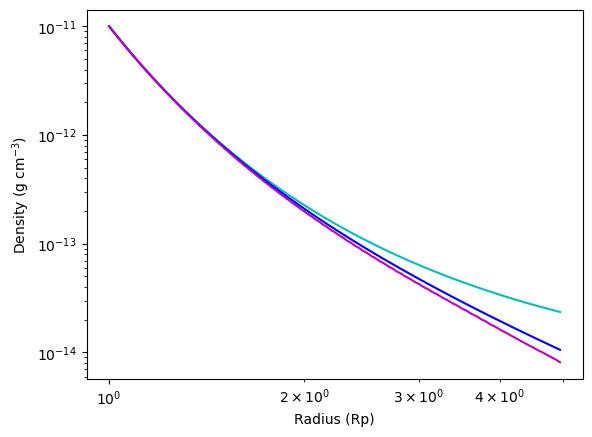

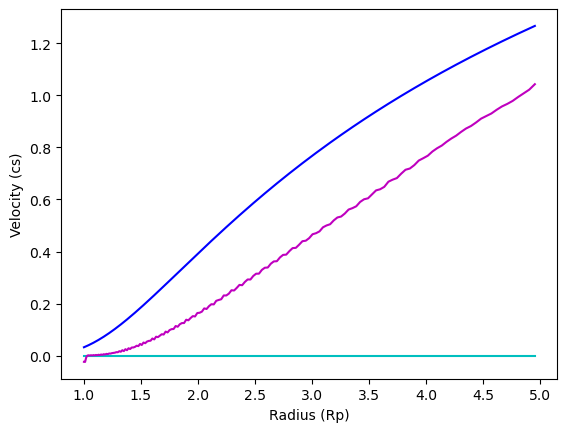

t = 8100.0 s
t = 8200.0 s
t = 8300.0 s
t = 8400.0 s
t = 8500.0 s
t = 8600.0 s
t = 8700.0 s
t = 8800.0 s
t = 8900.0 s
t = 9000.0 s
t = 9100.0 s
t = 9200.0 s
t = 9300.0 s
t = 9400.0 s
t = 9500.0 s
t = 9600.0 s
t = 9700.0 s
t = 9800.0 s
t = 9900.0 s
t = 10000.0 s
at outer boundary vout/cs =  1.0914838300205523


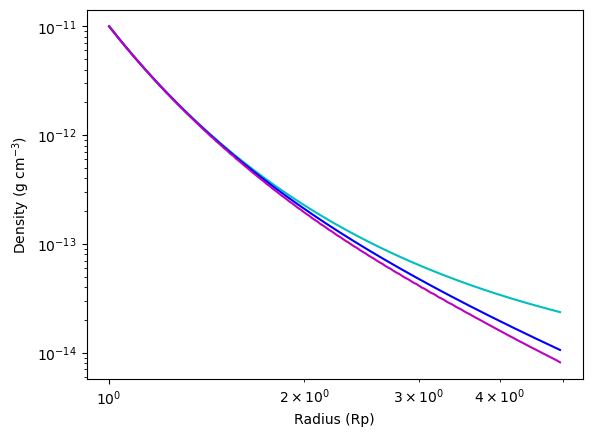

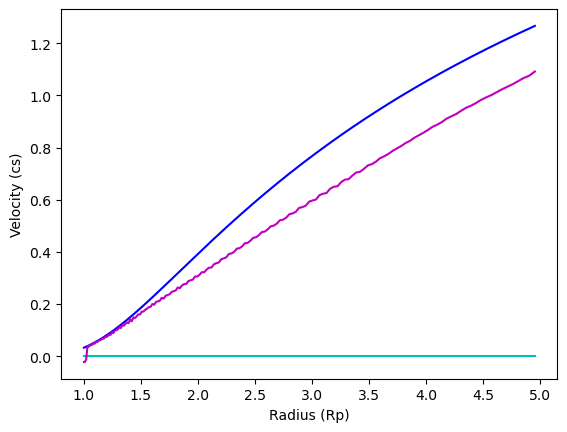

t = 10100.0 s
t = 10200.0 s
t = 10300.0 s
t = 10400.0 s
t = 10500.0 s
t = 10600.0 s
t = 10700.0 s
t = 10800.0 s
t = 10900.0 s
t = 11000.0 s
t = 11100.0 s
t = 11200.0 s
t = 11300.0 s
t = 11400.0 s
t = 11500.0 s
t = 11600.0 s
t = 11700.0 s
t = 11800.0 s
t = 11900.0 s
t = 12000.0 s
at outer boundary vout/cs =  1.1568951423064837


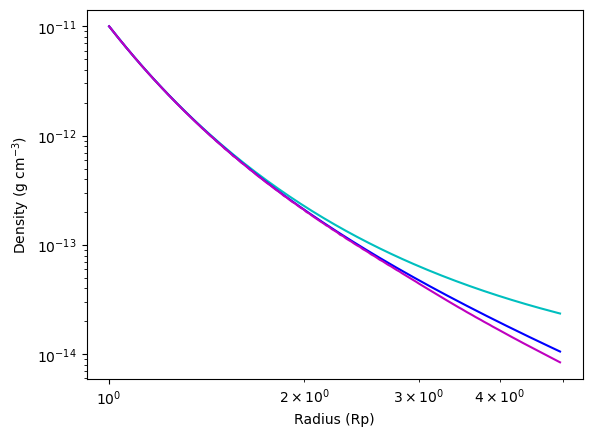

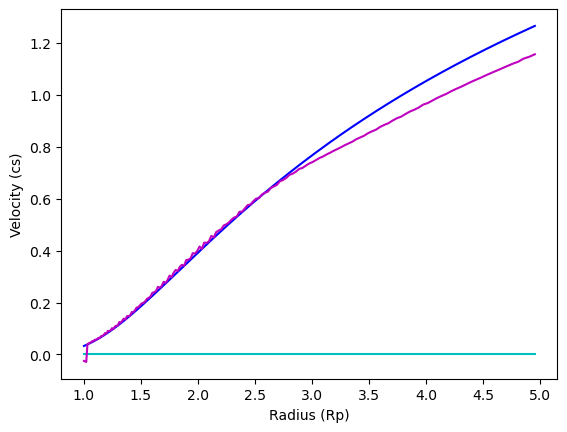

t = 12100.0 s
t = 12200.0 s
t = 12300.0 s
t = 12400.0 s
t = 12500.0 s
t = 12600.0 s
t = 12700.0 s
t = 12800.0 s
t = 12900.0 s
t = 13000.0 s
t = 13100.0 s
t = 13200.0 s
t = 13300.0 s
t = 13400.0 s
t = 13500.0 s
t = 13600.0 s
t = 13700.0 s
t = 13800.0 s
t = 13900.0 s
t = 14000.0 s
at outer boundary vout/cs =  1.2692933147224508


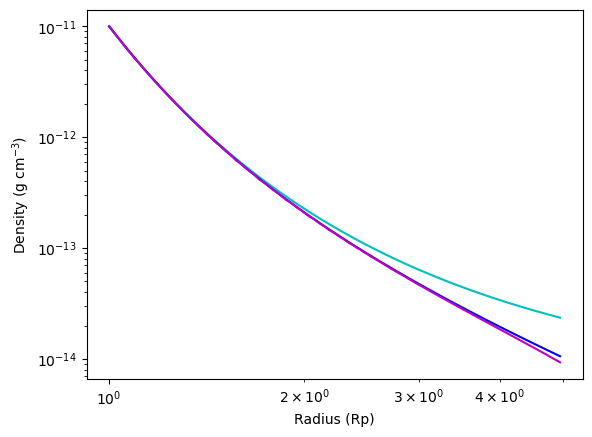

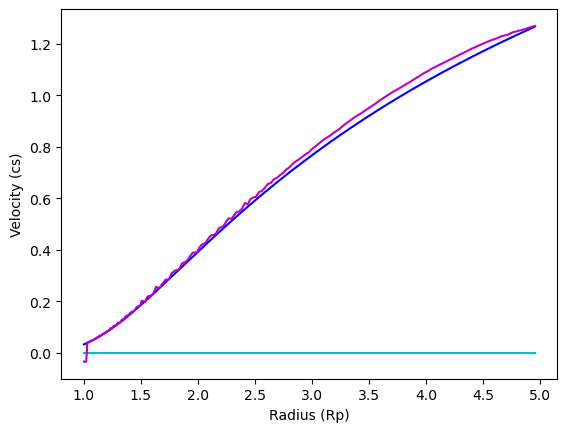

t = 14100.0 s
t = 14200.0 s
t = 14300.0 s
t = 14400.0 s
t = 14500.0 s
t = 14600.0 s
t = 14700.0 s
t = 14800.0 s
t = 14900.0 s
t = 15000.0 s
t = 15100.0 s
t = 15200.0 s
t = 15300.0 s
t = 15400.0 s
t = 15500.0 s
t = 15600.0 s
t = 15700.0 s
t = 15800.0 s
t = 15900.0 s
t = 16000.0 s
at outer boundary vout/cs =  1.320707175732757


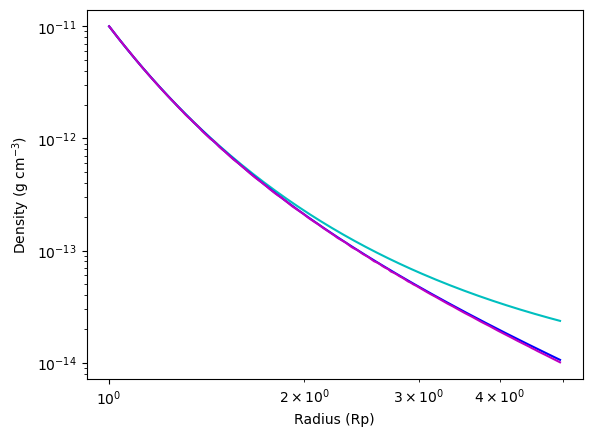

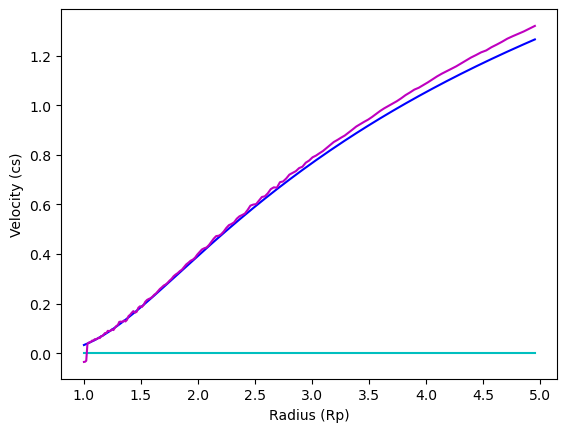

t = 16100.0 s
t = 16200.0 s
t = 16300.0 s
t = 16400.0 s
t = 16500.0 s
t = 16600.0 s
t = 16700.0 s
t = 16800.0 s
t = 16900.0 s
t = 17000.0 s
t = 17100.0 s
t = 17200.0 s
t = 17300.0 s
t = 17400.0 s
t = 17500.0 s
t = 17600.0 s
t = 17700.0 s
t = 17800.0 s
t = 17900.0 s
t = 18000.0 s
at outer boundary vout/cs =  1.3087407519088436


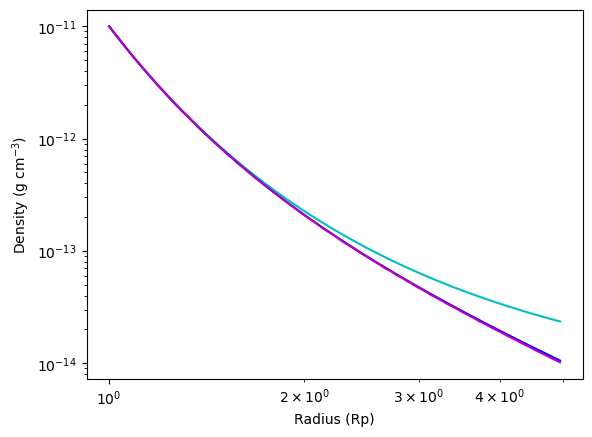

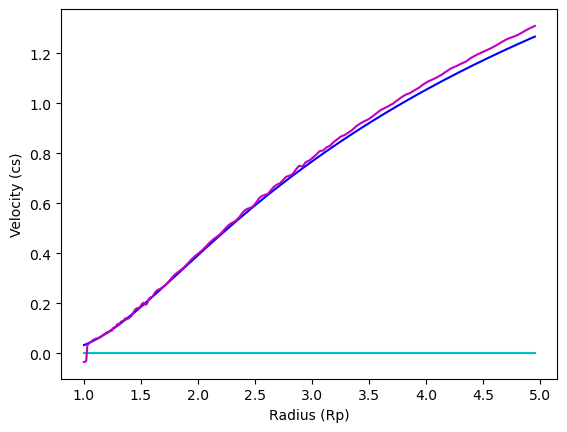

t = 18100.0 s
t = 18200.0 s
t = 18300.0 s
t = 18400.0 s
t = 18500.0 s
t = 18600.0 s
t = 18700.0 s
t = 18800.0 s
t = 18900.0 s
t = 19000.0 s
t = 19100.0 s
t = 19200.0 s
t = 19300.0 s
t = 19400.0 s
t = 19500.0 s
t = 19600.0 s
t = 19700.0 s
t = 19800.0 s
t = 19900.0 s
t = 20000.0 s
at outer boundary vout/cs =  1.2961894529634017


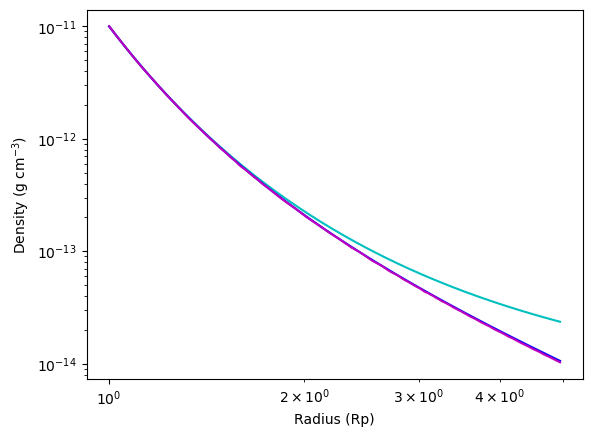

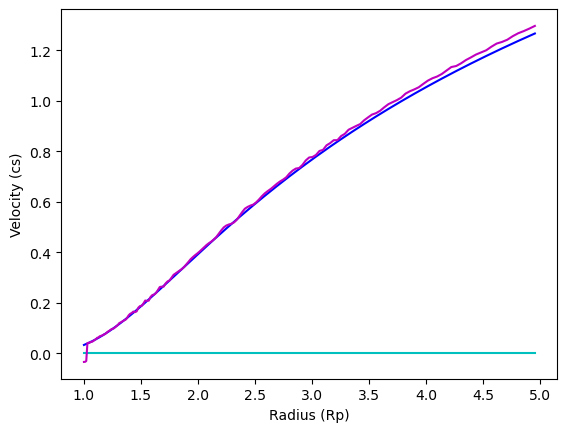

t = 20100.0 s
t = 20200.0 s
t = 20300.0 s
t = 20400.0 s
t = 20500.0 s
t = 20600.0 s
t = 20700.0 s
t = 20800.0 s
t = 20900.0 s
t = 21000.0 s
t = 21100.0 s
t = 21200.0 s
t = 21300.0 s
t = 21400.0 s
t = 21500.0 s
t = 21600.0 s
t = 21700.0 s
t = 21800.0 s
t = 21900.0 s
t = 22000.0 s
at outer boundary vout/cs =  1.2889996973410678


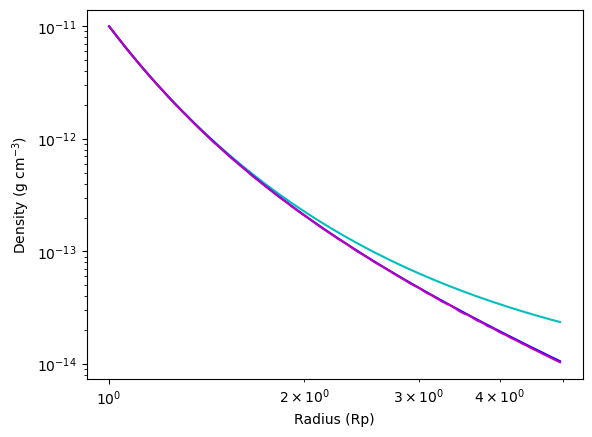

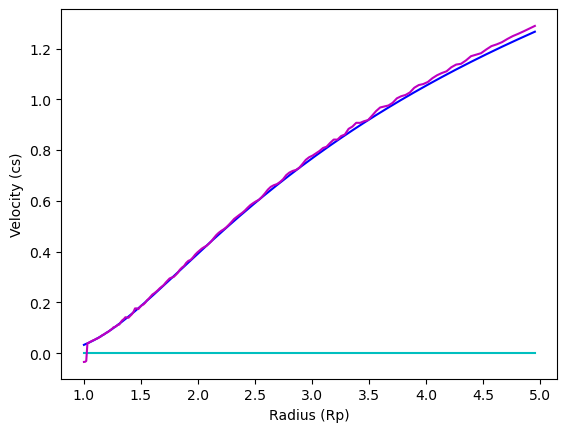

t = 22100.0 s
t = 22200.0 s
t = 22300.0 s
t = 22400.0 s
t = 22500.0 s
t = 22600.0 s
t = 22700.0 s
t = 22800.0 s
t = 22900.0 s
t = 23000.0 s
t = 23100.0 s
t = 23200.0 s
t = 23300.0 s
t = 23400.0 s
t = 23500.0 s
t = 23600.0 s
t = 23700.0 s
t = 23800.0 s
t = 23900.0 s
t = 24000.0 s
at outer boundary vout/cs =  1.28470317534748


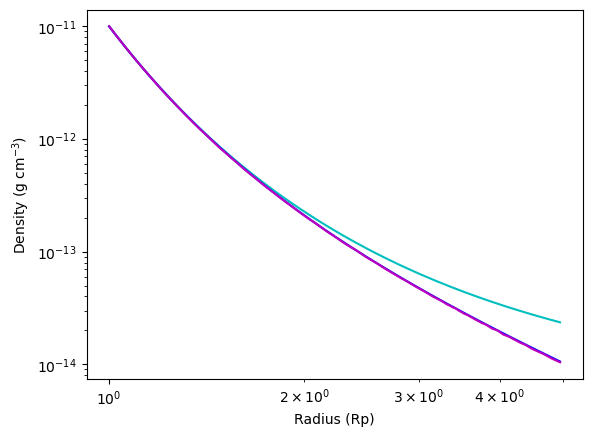

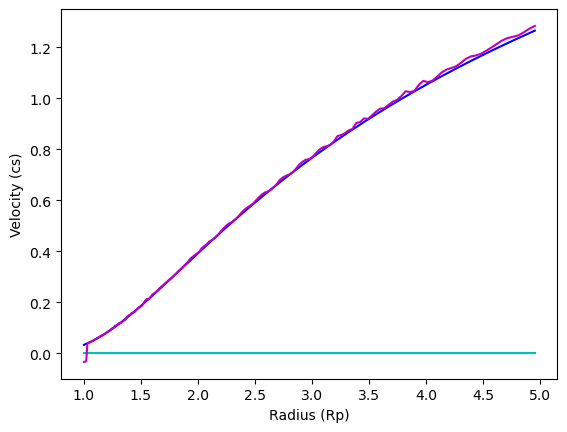

t = 24100.0 s
t = 24200.0 s
t = 24300.0 s
t = 24400.0 s
t = 24500.0 s
t = 24600.0 s
t = 24700.0 s
t = 24800.0 s
t = 24900.0 s
t = 25000.0 s
t = 25100.0 s
t = 25200.0 s
t = 25300.0 s
t = 25400.0 s
t = 25500.0 s
t = 25600.0 s
t = 25700.0 s
t = 25800.0 s
t = 25900.0 s
t = 26000.0 s
at outer boundary vout/cs =  1.2785530832231788


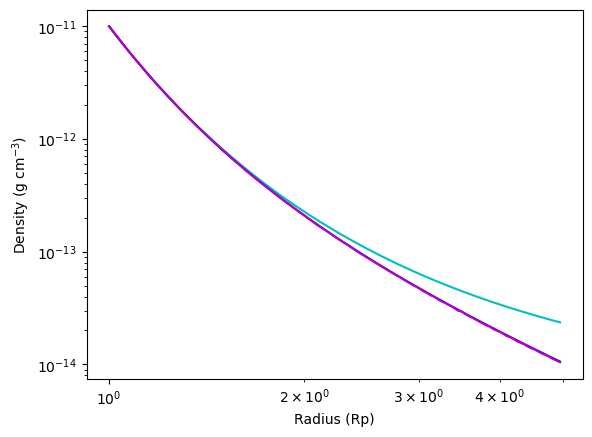

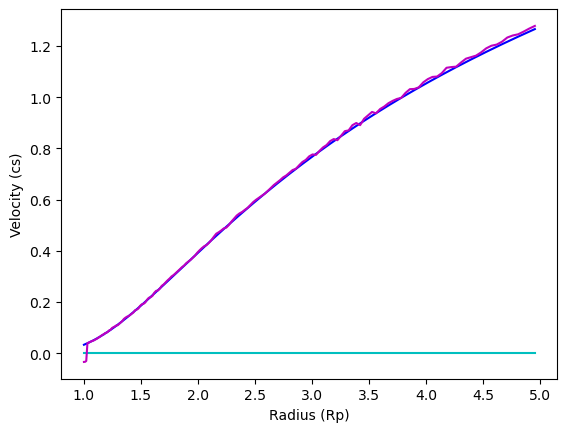

t = 26100.0 s
t = 26200.0 s
t = 26300.0 s
t = 26400.0 s
t = 26500.0 s
t = 26600.0 s
t = 26700.0 s
t = 26800.0 s
t = 26900.0 s
t = 27000.0 s
t = 27100.0 s
t = 27200.0 s
t = 27300.0 s
t = 27400.0 s
t = 27500.0 s
t = 27600.0 s
t = 27700.0 s
t = 27800.0 s
t = 27900.0 s
t = 28000.0 s
at outer boundary vout/cs =  1.274180192508012


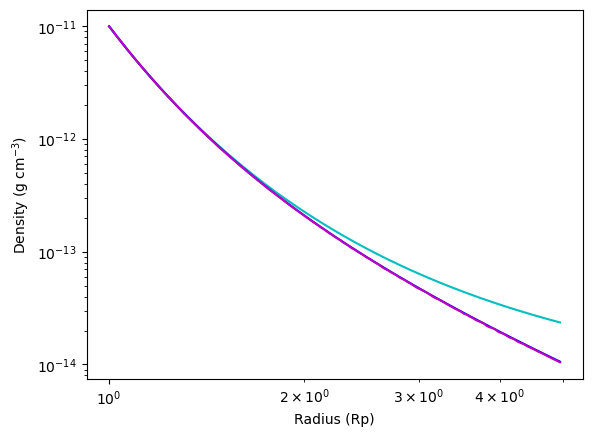

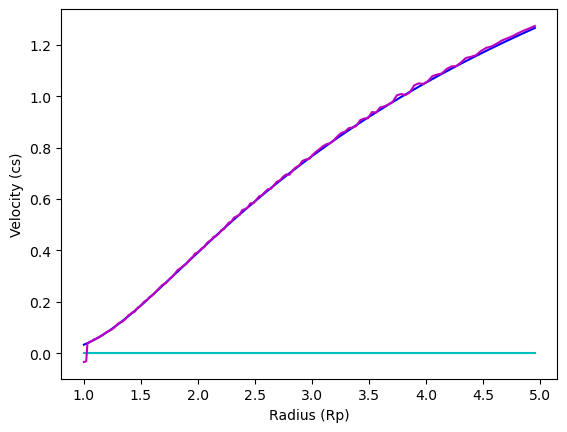

t = 28100.0 s
t = 28200.0 s
t = 28300.0 s
t = 28400.0 s
t = 28500.0 s
t = 28600.0 s
t = 28700.0 s
t = 28800.0 s
t = 28900.0 s
t = 29000.0 s
t = 29100.0 s
t = 29200.0 s
t = 29300.0 s
t = 29400.0 s
t = 29500.0 s
t = 29600.0 s
t = 29700.0 s
t = 29800.0 s
t = 29900.0 s


In [16]:
for i in range(ntimes-1):
    for j in range(1,nrs-1):
        
        delrho = (rho[j+1] - rho[j-1])/2.0
        delv = (v[j+1] - v[j-1])/2.0
        rhoavg = (rho[j+1]+rho[j-1])/2.0
        xavg = (x[j+1]+x[j-1])/2.0
        vavg = (v[j+1]+v[j-1])/2.0

        new_rho[j] = rho[j] + dt*(-np.exp(-xavg))*(2.0*rhoavg*vavg + rhoavg*delv/dx + vavg*delrho/dx)
        new_v[j] = v[j] + dt*( -vavg*np.exp(-xavg)*delv/dx - (cs**2/rhoavg)*np.exp(-xavg)*delrho/dx - G*Mp*np.exp(-2.*xavg) )
 
 
    # most cells
    for j in range(1,nrs-1): rho[j]= new_rho[j]
    for j in range(1,nrs-1): v[j] = new_v[j]
        
    # inner boundary
    vavg = (v[0]+v[1])/2.0
    xavg = (x[0]+x[1])/2.0
    rhoavg = (rho[0]+rho[1])/2.0
    delrho = (rho[1] - rho[0])
    delv = (v[1] - v[0])
    rho[0] = rho[0] + dt*(-np.exp(-xavg))*(2.0*rhoavg*vavg + rhoavg*delv/dx + vavg*delrho/dx)
    v[0] = v[0] + dt*( -vavg*np.exp(-xavg)*delv/dx - (cs**2/rhoavg)*np.exp(-xavg)*delrho/dx - G*Mp*np.exp(-2.*xavg) )
    # It's easy for waves to be launched at the base that destabilize the numerical solution.
    # I avoid this by damping the density to the hydrostatic solution in the first 5 cells.  
    # That's okay because we know the solution should be close to hydrostatic well below the sonic point.
    tdamp = dt
    ndamp = 5
    dampfac = np.linspace(1.0,0.0,ndamp)
    for ind in range(ndamp): 
        rho[ind] = rho[ind] + dampfac[ind]*(rho_hydrostat[ind]-rho[ind])/tdamp*dt
    
    # outer boundary
    vavg = (v[-1]+v[-2])/2.0
    xavg = (x[-1]+x[-2])/2.0
    rhoavg = (rho[-1]+rho[-2])/2.0
    delrho = (rho[-1] - rho[-2])
    delv = (v[-1] - v[-2])
    rho[nrs-1] = rho[nrs-1] + dt*(-np.exp(-xavg))*(2.0*rhoavg*vavg + rhoavg*delv/dx + vavg*delrho/dx)
    v[nrs-1] = v[nrs-1] + dt*( -vavg*np.exp(-xavg)*delv/dx - (cs**2/rhoavg)*np.exp(-xavg)*delrho/dx - G*Mp*np.exp(-2.*xavg) )
    # give it a little nudge over the sound speed boundary (the critical point is tricky for code)
    if (v[nrs-1] >= 0.99999*cs) and (v[nrs-1] <= 1.00001*cs): v[nrs-1] = 1.00001*cs 
        
    # save the output every dt_out
    if (i*dt)%dt_out == 0:
        print("t = " + str(i*dt) + " s")
        
        index = int(np.floor(i*dt/dt_out)) + 1
        np.copyto(rho_out[index], rho)
        np.copyto(v_out[index], v)
        
        # make plots showing the progress every once in a while
        if (index-1)%20 == 0:
            print("at outer boundary vout/cs = ", v_out[index][nrs-1]/cs) 
            
            plt.loglog(r/Rp, rho_out[0], 'c')  # cyan = initial hydrostatic solution
            plt.loglog(r/Rp, rho_wind_solved, 'b') # blue = transonic wind solution
            plt.loglog(r/Rp, rho_out[index], 'm') # magenta = solution at current time
            plt.xlabel('Radius (Rp)')
            plt.ylabel('Density (g cm$^{-3}$)')
            plt.show()
            
            plt.plot(r/Rp, v_out[0]/cs, 'c') # cyan = initial hydrostatic solution
            plt.plot(r/Rp, v_wind_solved/cs, 'b') # blue = transonic wind solution
            plt.plot(r/Rp, v_out[index]/cs, 'm') # magenta = solution at current time
            plt.xlabel('Radius (Rp)')
            plt.ylabel('Velocity (cs)')
            plt.show()